In [2]:
%matplotlib notebook
from segmentizer import Segmentizer
from segmentizer.data_loader import LASIESTADataLoader
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from tqdm import tqdm_notebook, tnrange
from IPython.display import clear_output
import seaborn as sns
import pandas as pd
from IPython.display import HTML

# Analyze the dataset

In [3]:
data_loader = LASIESTADataLoader('/Users/dsoellinger/Downloads/I_SI_01')
video_segmentizer = Segmentizer(352,288)

In [4]:
red_frame_statistics = [[[] for _ in range(353)]  for _ in range(288)] 
green_frame_statistics = [[[] for _ in range(353)]  for _ in range(288)] 
blue_frame_statistics = [[[] for _ in range(353)]  for _ in range(288)] 

data_loader.set_next_frame_idx(0)

for original_frame in tqdm_notebook(data_loader, total=data_loader.get_nr_of_frames()):
    for i, row in enumerate(original_frame):
        for j, rgb in enumerate(row):
            red_frame_statistics[i][j].append(rgb[0])
            green_frame_statistics[i][j].append(rgb[1])
            blue_frame_statistics[i][j].append(rgb[2])
           

HBox(children=(IntProgress(value=0, max=300), HTML(value='')))

## I_SI_01 - Analyze distribution of RED color channel

In [ ]:
fig, ax = plt.subplots(figsize=(20,20), nrows=5, ncols=5, sharey=True)

for i in range(5):
    for j in range(5):
        sns.distplot(red_frame_statistics[i*60][j*60], color='red', ax=ax[i][j])
        ax[i][j].legend(['x: ' + str(i*60) + ' / ' + 'y: ' + str(j*60)])
        
plt.show()

## I_SI_01 - Analyze distribution of GREEN color channel

In [ ]:
fig, ax = plt.subplots(figsize=(20,20), nrows=5, ncols=5, sharey=True)

for i in range(5):
    for j in range(5):
        sns.distplot(green_frame_statistics[i*60][j*60], color='green', ax=ax[i][j])
        ax[i][j].legend(['x: ' + str(i*60) + ' / ' + 'y: ' + str(j*60)])
        
plt.show()

## I_SI_01 - Analyze distribution of BLUE color channel

In [ ]:
fig, ax = plt.subplots(figsize=(20,20), nrows=5, ncols=5, sharey=True)

for i in range(5):
    for j in range(5):
        sns.distplot(blue_frame_statistics[i*60][j*60], color='blue', ax=ax[i][j])
        ax[i][j].legend(['x: ' + str(i*60) + ' / ' + 'y: ' + str(j*60)])
        
plt.show()

## "Running" histogram analysis

<IPython.core.display.Javascript object>


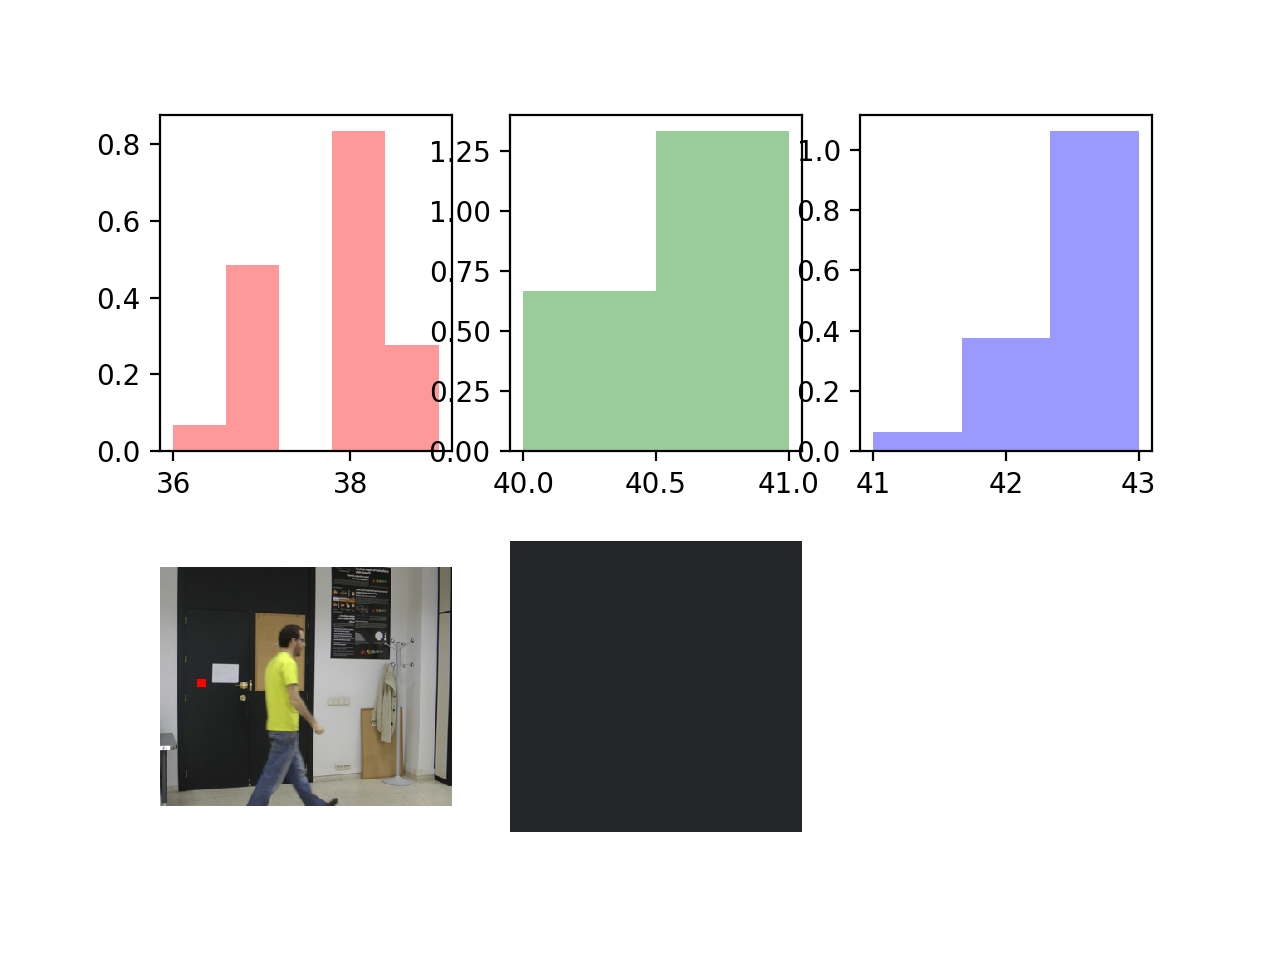

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:817: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bins


In [7]:
def _animate(i,y,x):

    fig.clf()
    ax1 = fig.add_subplot(231)
    ax2 = fig.add_subplot(232)
    ax3 = fig.add_subplot(233)
    ax4 = fig.add_subplot(234)
    ax5 = fig.add_subplot(235)

    # Histogram
    sns.distplot(red_frame_statistics[y][x][:i], kde=False, norm_hist=True, ax=ax1, color='red')
    sns.distplot(green_frame_statistics[y][x][:i], kde=False, norm_hist=True, ax=ax2, color='green')
    sns.distplot(blue_frame_statistics[y][x][:i], kde=False, norm_hist=True, ax=ax3, color='blue')
    
    # Full frame
    frame = data_loader.get_next_frame()
    marked_frame = frame.copy()
    marked_frame[y-5:y+5,x-5:x+5] = [255,0,0]
    ax4.imshow(marked_frame, animated=True)
    ax4.axis('off')

    # Relevant regions
    ax5.imshow([[frame[y,x]]], animated=True)
    ax5.axis('off')
    
    return fig

#def render_histogram_video(data_loader, x, y):
x = 50
y = 140
    #fig = plt.figure(figsize=(20,10))
fig = plt.figure()
fig.legend('Red Channel of pixel x: ' + str(x) + ' / y: ' + str(y) +')')

data_loader.set_next_frame_idx(0)

anim = animation.FuncAnimation(fig, _animate, frames=50, fargs=[y,x])
    #anim.save('histogram_I_SI_01_red_' + str(x) + '_' + str(y) + '.mp4', fps=5, extra_args=['-vcodec', 'libx264'])
from IPython.display import HTML
HTML(anim.to_jshtml(fps=20))
    #anim.to_html5_video()
    
    #print("Finished rendering video")
    
#render_histogram_video(data_loader, 50, 140)

## Warm up phase (Train the model)

In [ ]:
nr_frames_to_train = 100
frame_rate = 5    # Every frames is used x times during training
train_idx = 0

print('Start training - Using the first ' + str(nr_frames_to_train) + ' frames to train')
      
frame = data_loader.get_next_frame()
train_idx += 1
      
for _ in tnrange(nr_frames_to_train):
    for _ in range(frame_rate):
        video_segmentizer.fit(frame, init_weight=0.03, init_variance=36.0, lr=0.005)
      
    frame = data_loader.get_next_frame()
    train_idx += 1

In [ ]:
data_loader.set_next_frame_idx(0)

background_fig = plt.figure()
background_fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
plt.axis('off')

def animate(*args):
    clear_output(wait=True)
    print("Process frame: " + str(data_loader.get_next_frame_idx()))
    frame = data_loader.get_next_frame()
    background = video_segmentizer.fit_and_predict(frame, init_weight=0.03, init_variance=36.0, lr=0.005)
    return plt.imshow(background, animated=True, aspect='auto', vmin=0, vmax=1, cmap='gray')


anim = animation.FuncAnimation(background_fig, animate, frames=data_loader.get_nr_of_frames()-1)
anim.save('background_estimate_I_SI_01.mp4', fps=20, extra_args=['-vcodec', 'libx264'])
print("Done")

<video controls src="background_estimate_I_SI_01.mp4" />